# Pendientes

* convertir control en diccionario
* script mas complejo para proporcion
    - puede haber nulos, solucionar los faltantes
    - poder darle una lista de meses
* arreglar scripts para control
*reescribir optimizaicon de hiperparam

In [1]:
from datetime import datetime
import pandas as pd
import sys
import json
import os

In [2]:
NOMBRE_EXPERIMENTO = '2024-06-23_12Lags'
FOLDER = f'./Experimentos/{NOMBRE_EXPERIMENTO}/'

dibujar_pesos = False
lgbm_params = {
    'objective': 'regression',
    'metric': ['l2', 'rmse'],
    'boosting_type': 'gbdt',
    'num_leaves': 40,
    'max_bin': 1023,
    'learning_rate': 0.01,
    'force_col_wise' : True,
}

gen_config = {
    "nombre_exp" : NOMBRE_EXPERIMENTO,
    "folder" : FOLDER,
    "path_group" : "01_group.parquet",
    "path_prod_stats" : "01_prod_stats.parquet",
    "path_prod_data_group" : "01_prod_data_group.parquet",
    "path_prod_data_ungroup" : "01_prod_data_ungroup.parquet",
    "path_stock_data" : "01_stock_data.parquet",
    "path_norm" : "02_norm.parquet",
    "path_lag" : "03_lag.parquet",
    "path_train" : "04_train.parquet",
    "path_test" : "04_test.parquet",
    "path_futuro" : "04_futuro.parquet",
    "path_pred_test" : "05_pred_test.parquet",
    "path_pred_futuro" : "05_pred_futuro.parquet",
    "path_kaggle" : f"kaggle_{NOMBRE_EXPERIMENTO}.csv",

    "var_periodo_rep_start" : 201912,
    "var_periodo_rep_end" : 201912,
    "var_lags": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15,18,21,24,30,36],
    "var_cates_feat" : ['cat1', 'cat2', 'brand', 'descripcion'],

    "var_periodo_train_start" : 201701,
    "var_periodo_train_end" : 201909,
    "var_periodo_test" : 201910,
    "var_periodo_futuro" : 201912,

    "var_lgbm_params" : lgbm_params,
    "var_dibujar_pesos" : dibujar_pesos,
}

with open('gen_config.json', 'w') as file:
    json.dump(gen_config, file, indent=4)

if not os.path.exists(FOLDER):
    os.makedirs(FOLDER)
with open(f'{FOLDER}\gen_config.json', 'w') as file:
    json.dump(gen_config, file, indent=4)

In [3]:
original_stdout = sys.stdout 

with open(f'{FOLDER}\exp_config_out.txt', 'w') as file:
    sys.stdout = file

    print(f"{'Experimento':.^120}\n{gen_config['nombre_exp']:-^120}")
    print(f"{'CARPETA':.<25}: {gen_config['folder']}")
    for k, v in gen_config.items():
        if k == 'folder' or k == 'nombre_exp':
            continue
        if k.startswith('path_'):
            print(f"{k:.<25}: {v} ( {FOLDER}{v} )")
        if k.startswith('var_'):
            print(f"{k:.<25}: {v}")

sys.stdout = original_stdout

with open(f'{FOLDER}\exp_config_out.txt', 'r') as file:
    print(file.read())

......................................................Experimento.......................................................
---------------------------------------------------2024-06-23_12Lags----------------------------------------------------
CARPETA..................: ./Experimentos/2024-06-23_12Lags/
path_group...............: 01_group.parquet ( ./Experimentos/2024-06-23_12Lags/01_group.parquet )
path_prod_stats..........: 01_prod_stats.parquet ( ./Experimentos/2024-06-23_12Lags/01_prod_stats.parquet )
path_prod_data_group.....: 01_prod_data_group.parquet ( ./Experimentos/2024-06-23_12Lags/01_prod_data_group.parquet )
path_prod_data_ungroup...: 01_prod_data_ungroup.parquet ( ./Experimentos/2024-06-23_12Lags/01_prod_data_ungroup.parquet )
path_stock_data..........: 01_stock_data.parquet ( ./Experimentos/2024-06-23_12Lags/01_stock_data.parquet )
path_norm................: 02_norm.parquet ( ./Experimentos/2024-06-23_12Lags/02_norm.parquet )
path_lag.................: 03_lag.parquet ( ./E

----------------------------------------------COMIENZA----------------------------------------------
------------------------------------------01_LecturaDatos-------------------------------------------
Tamaño data_grouped......: (15416, 3)
Tamaño prod_stats........: (542, 11)
------------------------------------------01_LecturaDatos-------------------------------------------
----------------------------------------------FINALIZA----------------------------------------------

----------------------------------------------COMIENZA----------------------------------------------
--------------------------------------------02_normaliza--------------------------------------------
--------------------------------------------02_normaliza--------------------------------------------
----------------------------------------------FINALIZA----------------------------------------------

----------------------------------------------COMIENZA----------------------------------------------
--------------

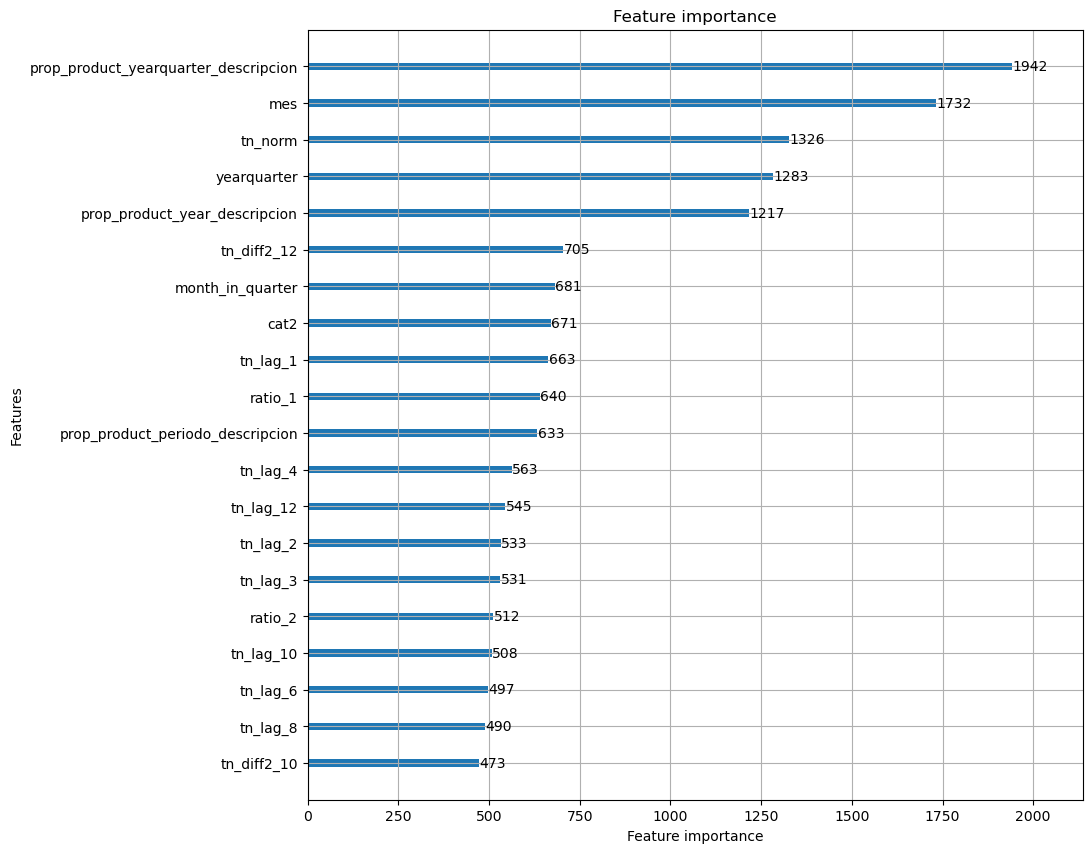

--------------------------------------05_lightgbm (un intento)--------------------------------------
----------------------------------------------FINALIZA----------------------------------------------

----------------------------------------------COMIENZA----------------------------------------------
---------------------------------------06_evaluar_prediccion----------------------------------------
Perdida en test (sin desagrupar): 0.2472558236481949
---------------------------------------06_evaluar_prediccion----------------------------------------
----------------------------------------------FINALIZA----------------------------------------------



In [4]:
%run 01_LecturaDatos.ipynb
%run 02_normaliza.ipynb
%run 03_features.ipynb
%run 04_crear_train_set.ipynb
%run 05_lightgbm.ipynb
%run 06_evaluar_prediccion.ipynb